In [1]:
# === 1. Import Library ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np


# === 2. Download NLTK Stopwords ===
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# === 3. Load Data CSV ===
fashion = pd.read_csv("fashion.csv")
elektronik = pd.read_csv("elektro.csv")
olahraga = pd.read_csv("olahraga_new (1).csv")

# === 4. Normalisasi nama kolom dan identifikasi kolom review ===
def normalize_and_clean(df):
    df.columns = df.columns.str.lower().str.replace(" ", "_")
    review_col = [col for col in df.columns if 'review' in col]
    if not review_col:
        raise ValueError("Kolom review tidak ditemukan.")
    review_col = review_col[0]
    df = df.drop_duplicates(subset=[review_col])
    df = df.dropna(subset=[review_col])
    return df, review_col

fashion_cleaned, review_col_fashion = normalize_and_clean(fashion)
elektronik_cleaned, review_col_elektronik = normalize_and_clean(elektronik)
olahraga_cleaned, review_col_olahraga = normalize_and_clean(olahraga)

# === 7. (Opsional) Cek hasil jumlah data ===
print(f"Fashion: {len(fashion)} → {len(fashion_cleaned)} setelah cleaning")
print(f"Elektronik: {len(elektronik)} → {len(elektronik_cleaned)} setelah cleaning")
print(f"Olahraga: {len(olahraga)} → {len(olahraga_cleaned)} setelah cleaning")

Fashion: 9963 → 3516 setelah cleaning
Elektronik: 9974 → 4437 setelah cleaning
Olahraga: 9041 → 5550 setelah cleaning


In [3]:
# === 5. Tambahkan kolom kategori ===
fashion_cleaned["kategori"] = "fashion"
elektronik_cleaned["kategori"] = "elektronik"
olahraga_cleaned["kategori"] = "olahraga"

# === 6. Gabungkan Data ===
data_lazada_all = pd.concat([fashion_cleaned, elektronik_cleaned, olahraga_cleaned], ignore_index=True)
# === 3. Cek hasil akhir ===
print(data_lazada_all["kategori"].value_counts())
print(data_lazada_all.head())

# === 4. (Opsional) Simpan ke file baru ===
# data_lazada_all.to_csv("data_lazada_labeled.csv", index=False)

kategori
olahraga      5550
elektronik    4437
fashion       3516
Name: count, dtype: int64
  web-scraper-order                              web-scraper-start-url  \
0      1749110533-1  https://www.lazada.co.id/products/pdp-i8191328...   
1      1749110533-2  https://www.lazada.co.id/products/pdp-i8191328...   
2      1749110533-3  https://www.lazada.co.id/products/pdp-i8191328...   
3      1749110533-4  https://www.lazada.co.id/products/pdp-i8191328...   
4      1749110533-5  https://www.lazada.co.id/products/pdp-i8191328...   

  username       tanggal                                             rating  \
0    M***i  5 bulan lalu  <img class="star" src="//img.lazcdn.com/g/tps/...   
1    L***a  7 bulan lalu  <img class="star" src="//img.lazcdn.com/g/tps/...   
2    M***i  6 bulan lalu  <img class="star" src="//img.lazcdn.com/g/tps/...   
3    I***h  7 bulan lalu  <img class="star" src="//img.lazcdn.com/g/tps/...   
4    L***h  7 bulan lalu  <img class="star" src="//img.lazcdn.com/g/

In [4]:
# === 7. Fungsi Pembersihan Teks ===
def clean_text(text):
    if pd.isnull(text): # Handle potential NaN values
        return ""
    text = str(text) # Ensure text is a string
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # hapus emoji
    text = re.sub(r'<.*?>', ' ', text)  # hapus tag html
    text = re.sub(r'http\S+', ' ', text)  # hapus URL
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # hapus simbol
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

review_col = [col for col in data_lazada_all.columns if 'review' in col][0]
data_lazada_all["cleaned_review"] = data_lazada_all[review_col].astype(str).apply(clean_text)

# === 3. Terapkan pembersihan teks pada kolom review ===
data_lazada_all["cleaned_review"] = data_lazada_all[review_col].astype(str).apply(clean_text)

# === 4. Cek hasil akhir ===
print(data_lazada_all[[review_col, "cleaned_review"]].head())

# === 5. (Opsional) Simpan hasil ke file ===
data_lazada_all.to_csv("data_lazada_cleaned_final.csv", index=False)

                                              review  \
0  gemesh bgt tweed nya wort it bangett ganyangka...   
1  ukuran XL cantik bnget di pakainya 😍😍 Cocok un...   
2  waaawhh😍😍😍 sebagus ini buat harga semurah itu ...   
3  bismillah semoga bermanfaat dan bisa membantu ...   
4  ukuran XL cakep parah 😍😍😍Cocok untuk berbagai ...   

                                      cleaned_review  
0  gemesh bgt tweed nya wort it bangett ganyangka...  
1  ukuran xl cantik bnget di pakainya cocok untuk...  
2  waaawhh sebagus ini buat harga semurah itu bne...  
3  bismillah semoga bermanfaat dan bisa membantu ...  
4  ukuran xl cakep parah cocok untuk berbagai uku...  


In [5]:
# === 8. Stopwords Tambahan dan Kata Kunci Produk ===
custom_stopwords = [
    # 1. Kata pelayanan & pengiriman
    "penjual", "seller", "admin", "cs", "customer", "service", "pelayanan", "layanan",
    "respon", "fastrespon", "slowrespon", "responsif", "responnya", "chat", "balas", "dibalas",
    "pengiriman", "dikirim", "kirim", "pengantar", "sampai", "sampainya", "datang", "telat",
    "lambat", "lama", "cepat", "terlalu cepat", "terlalu lama", "kurir", "ojol", "driver",
    "diantar", "terima", "diterima", "paket", "paketnya", "order", "pesanan", "pesanannya",

    # 2. Kata pengemasan
    "packing", "kemasan", "bungkus", "bubble", "wrap", "plastik", "kardus", "kotak", "dus", "box", "segel",
    "rapi", "berantakan", "rusak", "sobek", "retak", "bocor", "aman", "tidak aman",

    # 3. Ekspresi tidak informatif/berulang
    "bagus", "baguss", "bagusss", "mantap", "mantapp", "mantappp", "keren", "oke", "top", "sip",
    "makasih", "thanks", "terimakasih", "terima kasih", "suka", "sukaa", "sukaaa", "perfect",
    "puas", "cocok", "recommended", "rekomendasi", "worth", "worthit", "worth it", "yes", "lumayan",
    "love", "good", "nice", "great", "biasa", "b aja", "so so", "standar", "standard",

    # 4. Kata promosi & harga
    "harga", "murah", "mahal", "diskon", "promo", "potongan", "gratis", "cashback",
    "terjangkau", "deal", "value", "worth", "worth it", "promoan", "flashsale", "voucher",

    # 5. Kata tidak informatif/netral
    "barang", "produknya", "produk", "barangnya", "nya", "real", "asli", "ori", "original", "terbaik",
    "biasa", "biasa aja", "aja", "itu", "ini", "udah", "sudah", "lagi", "banget", "sekali", "nih",
    "dong", "deh", "doang", "malah", "kayak", "seperti", "pas", "cuma", "hanya", "baru", "lama", "juga",

    # 6. Kata chat/sapaan
    "gan", "sis", "min", "bos", "bro", "kak", "bang", "mbak", "om", "tante", "dear", "ci", "ko",
    "agansis", "juragan", "sob", "temen", "teman", "guys",

    # 7. Singkatan/informal
    "gt", "jd", "jg", "udh", "udah", "gk", "ga", "nggak", "ngga", "dr", "tp", "kyk", "yg", "blm",
    "sm", "bgt", "dl", "aja", "nya", "dtg", "lsg", "cm", "bbrp", "pdhl", "trs", "bs", "udh", "krn",
    "gini", "gitu", "bgitu", "trus", "udh", "udh bgt", "udh banget", "sbnrnya", "ntar", "kmrn", "sy",
    "aku", "gw", "gue", "loe", "lo", "saya", "kami", "kita", "anda", "ente", "elah", "lah", "mah"

    # Stopwords umum sangat sering muncul
    'yang', 'dan', 'di', 'ke', 'dengan', 'untuk', 'pada', 'ini', 'atau',
    'dari', 'adalah', 'itu', 'akan', 'saya', 'kita', 'sudah', 'juga', 'sebagai',
    'oleh', 'karena', 'tetapi', 'agar', 'jadi', 'bagi', 'dalam', 'lain',

    # Stopwords umum terkait review produk/kata umum
    'produk', 'barang', 'harga', 'beli', 'bagus', 'baik', 'terbaik', 'original',
    'oke', 'mantap', 'pas', 'suka', 'enak', 'nyaman', 'mudah', 'langsung',
    'dipakai', 'pakai', 'tokonya', 'penggunaan', 'pemakaian', 'terima', 'cepat',
    'tokonya', 'pokoknya', 'banget', 'sangat', 'asli', 'keluar', 'bener', 'kali',
    'juga', 'lagi', 'pake', 'dipake', 'lagi', 'cuman', 'dikit', 'gak', 'ga',
    'gampang', 'sayang', 'makasih', 'kasih', 'thanks', 'makasih', 'lumayan',
    'oke', 'keren', 'top', 'amanah', 'aman', 'pas', 'oke', 'oke', 'mantap',

    # Stopwords yang bisa jadi noise umum lain
    'foto', 'gambar', 'video', 'link', 'website', 'akun', 'user', 'komentar',
    'review', 'testimoni', 'rating', 'likes', 'followers', 'share', 'komen', 'lazada','alhamdulillah'
]

all_stopwords = stop_words.union(custom_stopwords)

# === 9. Tokenizer dan Filter Review Tidak Informatif ===
keyword_bermakna = [
    "desain", "model", "warna", "motif", "bahan", "kain", "jahitan", "ukuran", "fit", "nyaman",
    "lembut", "stretch", "ringan", "halus", "modis", "trendy", "kasual", "formal", "santai",
    "fashionable", "keren", "slimfit", "panjang", "pendek", "hangat", "tebal", "tipis", "layar",
    "resolusi", "kamera", "video", "baterai", "charger", "daya", "usb", "bluetooth", "wifi",
    "prosesor", "ram", "memori", "penyimpanan", "sensor", "speaker", "suara", "sinyal",
    "touchscreen", "responsif", "kecepatan", "sistem", "os", "android", "ios", "charging",
    "fitur", "kinerja", "fungsi", "port", "kabel", "tombol", "lampu", "display", "kaki", "lapangan",
    "grip", "lentur", "kuat", "tahan", "karet", "gerakan", "fleksibel", "elastis", "keringat",
    "ventilasi", "jalan", "lari", "training", "workout", "olahraga", "fitness", "sepatu",
    "jersey", "helm", "matras", "sadel", "handle", "stang", "ban", "bersepeda", "skate", "bola",
    "raket", "daya cengkeram"
]

def is_not_informative(text):
    has_stopword = any(word in text for word in custom_stopwords)
    lacks_keyword = not any(word in text for word in keyword_bermakna)
    return has_stopword and lacks_keyword

data_lazada_all = data_lazada_all[~data_lazada_all["cleaned_review"].apply(is_not_informative)]


=== FASHION ===


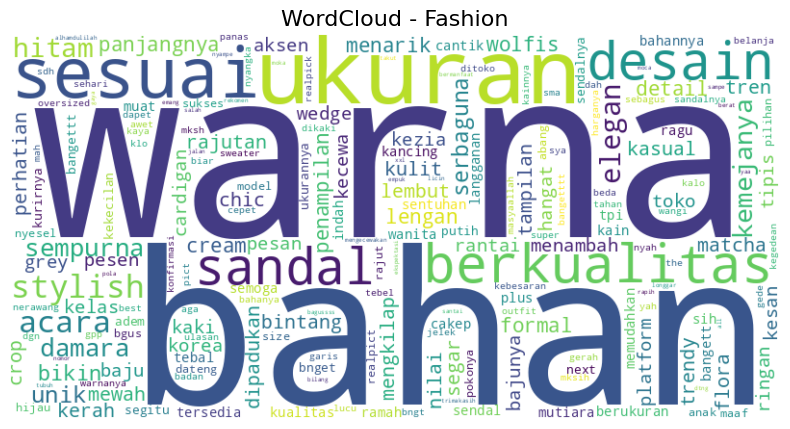

=== ELEKTRONIK ===


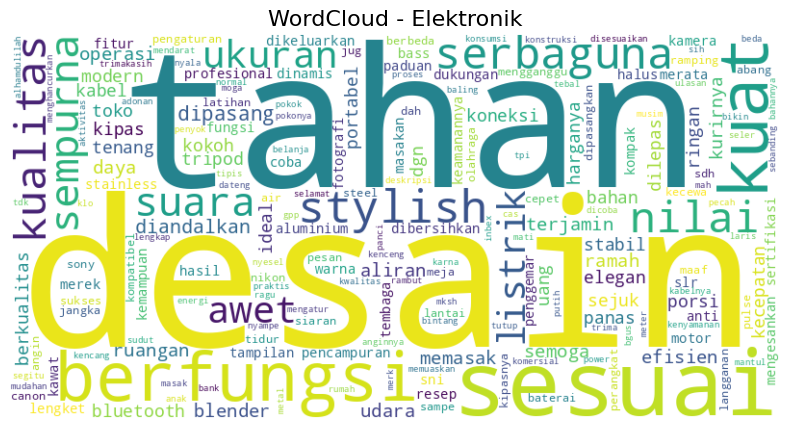

=== OLAHRAGA ===


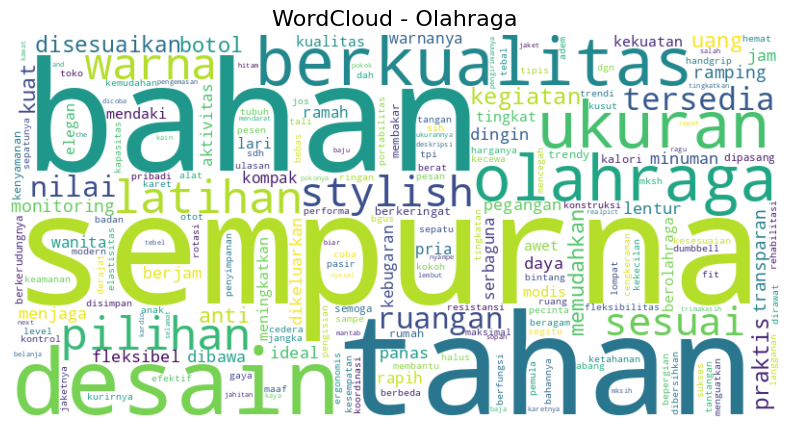

In [6]:
# === 10. Fungsi Tokenisasi dan WordCloud per Kategori ===
def tokenize_and_clean(text):
    tokens = text.translate(str.maketrans('', '', string.punctuation)).split()
    tokens = [word for word in tokens if word not in all_stopwords and len(word) > 2]
    return tokens

def generate_wordcloud_and_plot(df, category_name):
    all_words = []
    for text in df["cleaned_review"]:
        tokens = tokenize_and_clean(text)
        all_words.extend(tokens)

    word_freq = Counter(all_words)

    # WordCloud
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'WordCloud - {category_name.capitalize()}', fontsize=16)
    plt.show()

    # === 11. Visualisasi WordCloud dan Frekuensi ===
for kategori in data_lazada_all["kategori"].unique():
    print(f"=== {kategori.upper()} ===")
    subset_df = data_lazada_all[data_lazada_all["kategori"] == kategori]
    generate_wordcloud_and_plot(subset_df, kategori)

/tmp/ipython-input-7-2253732058.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')


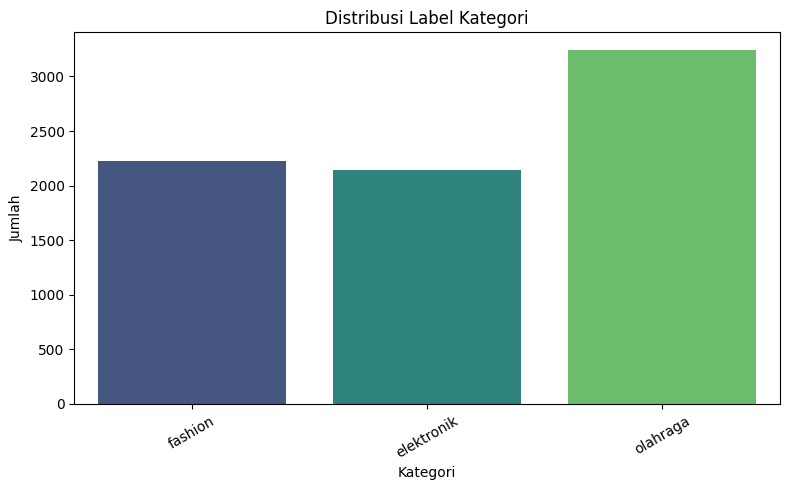

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5525 - loss: 0.9458 - val_accuracy: 0.5361 - val_loss: 0.8891
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8848 - loss: 0.3218 - val_accuracy: 0.7869 - val_loss: 0.5948
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9374 - loss: 0.1831 - val_accuracy: 0.7902 - val_loss: 0.4590
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9558 - loss: 0.1288 - val_accuracy: 0.7820 - val_loss: 0.5693
Epoch 5/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9613 - loss: 0.1152 - val_accuracy: 0.7820 - val_loss: 0.6440
Epoch 6/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9701 - loss: 0.0917 - val_accuracy: 0.7869 - val_loss: 0.6707
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


172/172 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.5997 - loss: 0.8558 - val_accuracy: 0.5311 - val_loss: 0.9010
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.8501 - loss: 0.3708 - val_accuracy: 0.7738 - val_loss: 0.6059
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.8905 - loss: 0.2875 - val_accuracy: 0.8328 - val_loss: 0.4284
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.9074 - loss: 0.2379 - val_accuracy: 0.8197 - val_loss: 0.4399
Epoch 5/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.9171 - loss: 0.2159 - val_accuracy: 0.8311 - val_loss: 0.4540
Epoch 6/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - accuracy: 0.9385 - loss: 0.1723 - val_accuracy: 0.8131 - val_loss: 0.5573
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.

=== Evaluation: Logistic Regression ===
              precision    recall  f1-score   support

  elektronik       0.89      0.78      0.83       

In [7]:
from sklearn.model_selection import train_test_split
import pandas as pd # Ensure pandas is imported if not already
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping


# Assuming data_lazada_all is available from previous cells
# Assuming cleaned_review column exists and clean_text function was applied

# Split kolom
X = data_lazada_all['cleaned_review'].astype(str)
y = data_lazada_all['kategori']

# Visualisasi distribusi label
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x=y, palette='viridis')
plt.title('Distribusi Label Kategori')
plt.xlabel('Kategori')
plt.ylabel('Jumlah')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Tokenisasi dan Padding
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
MAXLEN = 60
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAXLEN, padding='post')
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAXLEN, padding='post')

# Label encoding
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = len(le.classes_)
y_train_cat = tf.keras.utils.to_categorical(y_train_enc, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test_enc, num_classes)

# CLass Weight
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_enc), y=y_train_enc)
class_weights_dict = dict(enumerate(class_weights))

# TF-IDF untuk ML klasik
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2)) # Removed stop_words='indonesian'
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,              # berhenti jika val_loss tidak membaik selama 3 epoch
    restore_best_weights=True,
    verbose=1
)

# ANN Model
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

ann = models.Sequential([
    layers.Embedding(input_dim=5000, output_dim=64, input_length=MAXLEN),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

ann.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

ann.fit(
    X_train_seq, y_train_cat,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

lstm = models.Sequential([
    layers.Embedding(5000, 128, input_length=MAXLEN),
    layers.SpatialDropout1D(0.3),
    layers.Bidirectional(layers.LSTM(64)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm.fit(
    X_train_seq, y_train_cat,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# ML klasik models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

models_ml = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1),
    "SVM": LinearSVC(C=1),
}

for name, model in models_ml.items():
    model.fit(X_train_tfidf, y_train)

# Evaluasi
from sklearn.metrics import classification_report

def eval_model(name, y_true, y_pred):
    print(f"\n=== Evaluation: {name} ===")
    print(classification_report(y_true, y_pred))

# Evaluasi ML
for name, model in models_ml.items():
    preds = model.predict(X_test_tfidf)
    eval_model(name, y_test, preds)

# Evaluasi ANN
pred_ann = ann.predict(X_test_seq)
pred_ann_labels = le.inverse_transform(pred_ann.argmax(axis=1))
eval_model("ANN", y_test, pred_ann_labels)

# Evaluasi LSTM
pred_lstm = lstm.predict(X_test_seq)
pred_lstm_labels = le.inverse_transform(pred_lstm.argmax(axis=1))
eval_model("LSTM", y_test, pred_lstm_labels)

In [9]:
# 1. Import library yang diperlukan
import pandas as pd
from tkinter import Tk # Commented out for Colab
from tkinter.filedialog import askopenfilename # Commented out for Colab

# 2. (Opsional) Menggunakan File Dialog GUI (untuk lokal Python)
# Comment ini jika kamu pakai Google Colab
#Tk().withdraw()  # Agar jendela utama tidak muncul # Commented out for Colab
file_path = ('Book1.csv') # Using a direct path for Colab

# 3. Baca file CSV
df_input = pd.read_csv(file_path)

# 4. Tampilkan data untuk validasi
print("\nData yang dimuat:")
print(df_input.head())

# 5. Pastikan kolom 'Review' tersedia (menggunakan nama kolom yang benar)
if 'Review' not in df_input.columns:
    raise ValueError("Kolom 'Review' tidak ditemukan dalam file CSV!")

# 6. Bersihkan dan prediksi kategori
# Ensure clean_text, tokenizer, MAXLEN, lstm, and le are defined from previous cells
# Use the correct column name 'Review'
df_input['clean'] = df_input['Review'].apply(clean_text)
X_seq = pad_sequences(tokenizer.texts_to_sequences(df_input['clean']), maxlen=MAXLEN)
pred = lstm.predict(X_seq).argmax(axis=1)
df_input['predicted_kategori'] = le.inverse_transform(pred)

# 7. Tampilkan hasil
print("\nHasil Prediksi:")
print(df_input[['Review', 'predicted_kategori']])

# 8. Simpan hasil ke file baru
output_path = "hasil_prediksi.csv"
df_input.to_csv(output_path, index=False)
print(f"\nHasil prediksi disimpan di: {output_path}")


Data yang dimuat:
  web-scraper-order                              web-scraper-start-url  \
0      1749504497-1  https://www.lazada.co.id/products/pdp-i6987490...   

     Username       Tanggal  \
0  kurniasari  4 bulan lalu   

                                              Rating                   Varian  \
0  <img class="star" src="//img.lazcdn.com/g/tps/...  MAROON, Muat BB 50-85Kg   

                                              Review  
0  Suka desain berkerudungnya!, Berkeringat lebih...  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

Hasil Prediksi:
                                              Review predicted_kategori
0  Suka desain berkerudungnya!, Berkeringat lebih...           olahraga

Hasil prediksi disimpan di: hasil_prediksi.csv
